# ReFace Advanced Implementation

## Obiettivi

1. Acquisire il Database senza label e generare dataset apposito
2. Sfruttando gli algoritmi studiati generare dei cluster 
3. Salvare tutte le informazioni rilevanti ogni immagine (con il volto noto)
4. Generare gli embedded medi di ogni cluster
5. Analizzare una nuova immagine ed essere capace di capire se è parte di un cluster

## Progressi

1. Integrare il concetto di "Più persone in un Immagine"


In [ ]:
%git clone https://github.com/serengil/deepface.git

In [14]:
from model.Facenet512 import loadModel
from deepface import DeepFace
import numpy as np
import pandas as pd
from rich.console import Console
import cv2
import os

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

from PIL import Image
from pillow_heif import register_heif_opener
register_heif_opener()
import uuid

In [3]:
console = Console()
database = "data/"
weights = "weights/facenet512_weights.h5"
backends = "mtcnn"
target_size = (160, 160)

os.makedirs("database", exist_ok=True)

In [4]:
model = loadModel(weights_path=weights)
console.log("FaceNet512 loaded")

[12:50:11] FaceNet512 loaded                                                                        ]8;id=345116;file:///var/folders/km/120p9crx77scwcfclv6zynfr0000gn/T/ipykernel_8026/1095772783.py\1095772783.py]8;;\:]8;id=690918;file:///var/folders/km/120p9crx77scwcfclv6zynfr0000gn/T/ipykernel_8026/1095772783.py#2\2]8;;\

# Preparazione Immagini

prima di cominciare per una questione *organizzazitva* andiamo a sostitutire i nominativi di ogni immagine in un **uuid()** e convertiamo tutte le immagini in **jpg**

In [5]:
def convert_heic_to_jpg(heic_file_path):
    temp_img = Image.open(heic_file_path)
    png_photo = heic_file_path.replace('.HEIC','.png')
    temp_img.save(database + uuid.uuid4() + ".png")
    os.remove(heic_file_path)
    return heic_file_path[:-5] + ".jpg"

In [6]:
for image in os.listdir(database):
    try : 
        uuid.UUID(image[:-4])
        continue

    except:

        if image.endswith(('.heic', '.heif', '.HEIC', '.HEIF')):
            
            try:
                image_path = convert_heic_to_jpg(database + image)
            except :
                os.remove(database + image)
                continue        

        os.rename(database + image, database + str(uuid.uuid4()) + ".jpg")


# Generazione Dataset

Questo dataset è la nostra parallelizzazione di un Database

In [7]:
database_df = pd.DataFrame(columns=["img", "identity"])
database_df = database_df.set_index("img")

for image in os.listdir(database):
    database_df.loc[image] = {"identity": -1}

# Questo è il dataframe è quello operativo che contiene le immagini e le loro identità
df = pd.DataFrame(columns=["img", "embedded"])


# Identificazione e Cluster Del Singolo Volto!

In [143]:
def find_image_embedded(img_path):
    try:
        face_objs = DeepFace.extract_faces(img_path, detector_backend = backends, target_size = target_size, verbose=False)
    except:
        with open("../../log/missing_faces.log", "a") as f:
            f.write(img_path + "\n")
        return Exception("Face not found")
    # In questo caso diamo per scontato che ci sia una sola faccia
    print(face_objs[0])
    user_face = face_objs[0]['face'] 
    user_face_expanded = np.expand_dims(user_face, axis=0)
    embedded = model.predict(user_face_expanded, verbose=0)[0].tolist()

    return embedded

In [ ]:
num_images = len(os.listdir(database))
checked_images = 0
console.log("Inizio ad analizzare i volti presenti nel database ["+ str(num_images) +"]")

for image in os.listdir(database):

    img_path = database + image

    try:
        embedded = find_image_embedded(img_path)
    except:
        continue
    
    df.loc[len(df)] = {"img": image, "embedded": embedded}

    checked_images += 1

    if checked_images % int(num_images / 10) == 0 or checked_images == num_images or checked_images == 1: 
        console.log("[bold green]" + str(checked_images) + " / " + str(num_images) +  "[/bold green]" + " immagini Controllate")


console.log("Ho analizzato tutti i volti presenti nel database")

# Generazione dei Cluster

Andiamo ad utilizzare algoritmi com DBSCAN per ottenere una suddivisione iniziale su cui lavorare

I cluster rappresentano dei gruppi di immagine che raffigurano la giusta persona

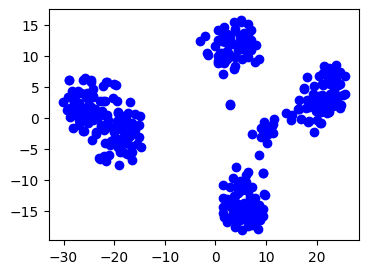

In [10]:
data = df["embedded"].to_list()
data = np.array(data)

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(data)

plt.figure(figsize=(4, 3))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c="blue")

# Otteniamo il miglior parametro eps per il nostro DBSCAN

ricordiamo che il parametro eps rappresenta la distanza massima tra due embedding per essere definiti equivalenti,
operazione che abbiamo già prosto nella nostra demo live per verificare se il volto in webcam apparteneva qualcuno

In [13]:
def find_best_eps(data):

    eps_min = 10.0  # Valore minimo di eps da esplorare.
    eps_max = 20.0  # Valore massimo di eps da esplorare.
    eps_step = 0.1  # Passo di incremento per eps.

    best_eps = None
    best_score = -1

    for eps in np.arange(eps_min, eps_max, eps_step):
        dbscan = DBSCAN(eps=eps, min_samples=4, metric='euclidean')
        dbscan.fit(data)
        labels = dbscan.labels_
        
        # Calcola il coefficiente di Silhouette per valutare la qualità del clustering.
        score = silhouette_score(data, labels)
        
        # Confronta il punteggio con il miglior punteggio finora.
        if score > best_score:
            best_score = score
            best_eps = eps

            
    return best_eps


# Effettuiamo il vero Cluster con il miglior parametro

[16:56:08] Il valore di eps è: 17.799999999999972                                                    ]8;id=447153;file:///var/folders/km/120p9crx77scwcfclv6zynfr0000gn/T/ipykernel_8026/216019032.py\216019032.py]8;;\:]8;id=883626;file:///var/folders/km/120p9crx77scwcfclv6zynfr0000gn/T/ipykernel_8026/216019032.py#2\2]8;;\

           Numero di cluster trovati: 12                                                             ]8;id=802841;file:///var/folders/km/120p9crx77scwcfclv6zynfr0000gn/T/ipykernel_8026/216019032.py\216019032.py]8;;\:]8;id=751196;file:///var/folders/km/120p9crx77scwcfclv6zynfr0000gn/T/ipykernel_8026/216019032.py#8\8]8;;\

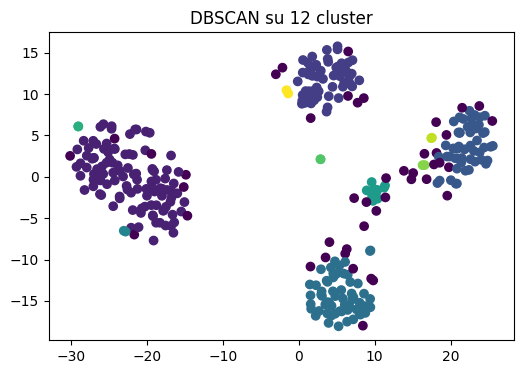

In [89]:
eps = find_best_eps(data)
console.log("Il valore di eps è: " + str(eps))

dbscan = DBSCAN(eps=eps, min_samples=2, metric='euclidean')
dbscan.fit(data)
labels = dbscan.labels_

console.log("Numero di cluster trovati: " + str(len(set(labels))))

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(data)

plt.figure(figsize=(6, 4))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels)
plt.title("DBSCAN su " + str(len(set(labels))) + " cluster")

plt.show()


# Andiamo ad Salvare tutti i Cluster ed ad Esportare il nostro db

In [90]:
for i in range(len(labels)):
    database_df.loc[df["img"][i]]["identity"] = labels[i]

database_df.to_csv("../../database/database.csv")

# Andiamo a Calcolare gli Embedding Medi di ogni Cluster

In [145]:
# Generiamo una lista contente i cluster trovati
clusters = list(set(labels))
clusters.sort()
clusters.remove(-1)

df_embedded = pd.DataFrame(columns=["cluster", "embedded","copertina"])
df_embedded = df_embedded.set_index("cluster")

# per ogni cluster identificare gli embedded che lo compongono e calcolare la media
for cluster in clusters:
    df_embedded.loc[len(df_embedded)] = {"cluster": cluster, "embedded": np.mean(df[df["img"].isin(database_df[database_df["identity"] == cluster].index)]["embedded"].to_list(), axis=0), "copertina": database_df[database_df["identity"] == cluster].index[0]}

df_embedded.to_csv("../../database/embedded.csv")


# Generiamo il Sistema di acquisizione di nuove immagini

    - Prendiamo una nuova immagine
    - Verifichiamo se è presente un volto
    - Generiamo l'embedding del volto
    
    - Verifichiamo se il volto è associabile ad un cluster
        - Se è associabile lo identifichiamo come volto noto

    - Se non è associabile lo identifichiamo come nuovo volto


## Implementiamo il modello NearestNeighbors per la ricerca del volto più vicino

In [146]:
embeddings = df_embedded["embedded"].to_list()
clusters = df_embedded.index.to_list()

nn_model = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn_model.fit(embeddings)


NearestNeighbors(algorithm='ball_tree', n_neighbors=1)

In [148]:
def add_new_image(image_path):
    
    # open the image and save in the data folder
    try:
        new_name = str(uuid.uuid4())
        img = Image.open(image_path)
        img.save("../../data/" + new_name + ".jpg")

    except Exception as e:
        return Exception(e)
    
    embedded = find_image_embedded(image_path)

    df.loc[len(df)] = {"img": image_path, "embedded": embedded}

    distance, index = nn_model.kneighbors([embedded])

    if distance[0][0] < eps:
        # Se la distanza è minore di eps allora è un volto già presente nel database
        # Quindi lo aggiungiamo al cluster corrispondente

        ## Aggiungere il volto al cluster corrispondente
        database_df.loc[new_name + ".jpg"] = {"identity": clusters[index[0][0]]}
        # esporta il database
        database_df.to_csv("./database/database.csv")

        console.log("il volto " + str(new_name) +  " è stato aggiunto al cluster " + str(clusters[index[0][0]]) + " con distanza " + str(distance[0][0]) )

    else:
        database_df.loc[new_name + ".jpg"] = {"identity": -1}
        database_df.to_csv("./database/database.csv")


In [142]:
add_new_image("../../provinaaaa.JPG")

[17:41:34] il volto dc582419-5541-4642-842b-532254a941ca è stato aggiunto al cluster 0 con         ]8;id=499456;file:///var/folders/km/120p9crx77scwcfclv6zynfr0000gn/T/ipykernel_8026/2153975257.py\2153975257.py]8;;\:]8;id=358826;file:///var/folders/km/120p9crx77scwcfclv6zynfr0000gn/T/ipykernel_8026/2153975257.py#27\27]8;;\
           distanza 14.59208934125638                                                                              

In [144]:
embedded = find_image_embedded("../../provinaaaa.JPG")

{'face': array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32), 'facial_area': {'x': 893, 'y': 1714, 'w': 673, 'h': 858}, 'confidence': 0.999595